In [1]:
from random import random, randint
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Union
import plotly.express as px

pd.options.plotting.backend = "plotly"

In [2]:
def compare_sign(effective, received):
    if not received:
        return False
    for sign in received:
        if not effective.get(sign):
            continue
        if effective[sign][-1] != received[sign][-1]:
            return False
    return True

In [3]:
def vectorized_min(baseline: Union[int, float], array: np.ndarray) -> np.ndarray:
    """
    Maps the min function to a np.ndarray given desired baseline minimum.

    Args:
        baseline: Minimum value to substitute if values within array are bigger
        array: Array with values to be compared to baseilne

    Returns:
        Array with leveraged numbers, all equal to or lower than the baseline

    >>> vectorized_min(2, np.array([1, 3, 4, -1])
    array([1, 2, 2, -1])
    """
    return np.array([min(baseline, x) for x in array])

In [4]:
def avg(array) -> Union[np.ndarray, pd.DataFrame]:
    """
    Calculates the average between multiple numpy arrays or pandas dataframe columns.

    Args:
        array: Array containing multiple numpy arrays or pandas dataframes

    Returns:
        Single numpy array or dataframe with average values element or column-wise
        respectivelly

    >>> avg([pd.DataFrame.from_dict({"x": [1, 2, 3]}), pd.DataFrame.from_dict({"x": [3, 3, 3]})])
        x
    0   2
    1   2
    2   3
    """
    result = sum(array) / len(array)
    if isinstance(result, np.ndarray):
        return result.astype(np.int32)
    else:
        return result.astype('int')

In [5]:
class SimulateEpidemic:
    def __init__(self, starting_values, model=np.random.poisson, rates=None):
        """
        Simulates an Epidemic Scenario given starting values and desired rate model for
        predicting new contagions and recovery values.

        Args:
            starting_values: A dictionary containing arrays of starting values:
                {"num_susceptible",
                "num_infected",
                "num_hospitalized",
                "num_recovered"}
            model: Model to generate new rates for each simulation time step, defaults to the Poisson Distribution.
        """
        self.susceptible = starting_values.get("num_susceptible", [int(1e4)])
        self.infected = starting_values.get("num_infected", [20])
        self.hospitalized = starting_values.get("num_hospitalized", [0])
        self.recovered = starting_values.get("num_recovered", [0])
        self.population_size = np.sum(list(starting_values.values()))
        self.population_size = int(self.population_size)

        self.curr_time = 1
        if rates is None:
            rates = {}
        self.agglomeration_frequency = rates.get("agglomeration_frequency", 1/15)
        self.hospitalized_rate = rates.get("hospitalized_rate", 0.05)
        self.model = model

    # Default constants to perform rate and average values update calculations
    beta_zero = 0.2592
    gamma_infected = 0.07143
    gamma_hospitalized = 0.03751

    @property
    def keys(self):
        """Returns the simulation population update history as a dictionary."""
        return {"susceptible": self.susceptible, "infected": self.infected,
                "hospitalized": self.hospitalized, "recovered": self.recovered}

    @property
    def df(self):
        """Returns the simulation population update history as a Pandas DataFrame."""
        return pd.DataFrame.from_dict(self.keys)

    @property
    def beta(self):
        """Calculate the used beta variable given agglomeration_frequency and initial beta values."""
        if random() <= self.agglomeration_frequency:
            return self.beta_zero * 3
        else:
            return self.beta_zero

    def update(self, variable, increment, is_new=True, timeframe=-1):
        """
        Adds a new timeframe to a single population variable, with given increment,
        or update variable at given timeframe if is_new=False.

        Args:
            variable: Instance population variable to increment, can be either self.infected,
            self.hospitalized, self.recovered or self.susceptible
            increment: Value to increase selected timeframe by
            is_new: Defaults to True, in which case a new entry is added to the end of the selected
            population history. If False, value at given timeframe is incremented
            timeframe: Used if is_new = False to update a single timeframe value

        Examples:
            >>> self.update(self.infected, 100)
            # self.infected[-1] = self.infected[-2] + 100
        """
        if is_new:
            next_value = variable[timeframe] + increment
            variable.append(next_value)
        else:
            variable[self.curr_time] += increment
            if variable[self.curr_time] < 0:
                variable[self.curr_time] = 0

    def step(self, recoveries, contagions):
        """Performs a single simulation step, given new recoveries and new contagions."""
        self.update(self.recovered, sum(recoveries))
        self.update(self.susceptible, -sum(contagions))

        self.update(self.hospitalized, contagions[0])
        self.update(self.hospitalized, -recoveries[0], False)

        self.update(self.infected, contagions[1])
        self.update(self.infected, -recoveries[1], False)

    def apply_model(self, iterable: iter) -> list:
        """Maps the desired Instance model to a given iterable variable, returning generated list"""
        return list(map(self.model, iterable))

    def avg_recovery(self, is_hospitalized=False):
        """Calculate the expected recoveries using the last time frame values."""
        if is_hospitalized:
            return self.gamma_hospitalized * self.hospitalized[-1]
        else:
            return self.gamma_infected * self.infected[-1]

    def avg_contagions(self, time_step=1):
        """Calculate the expected new contagions using the last time frame values."""
        return self.beta * (self.infected[-1] + self.hospitalized[-1]) * self.susceptible[-1] / self.population_size

    def run(self, remaining_time, stop_sign=None, time_step=1):
        """
        Performs simulation of the given input parameters up until remaining time is
        zero or the stop_sign has been reached.
        The simulation updates the history of each population variable per loop, with given
        constant rates and considering the inputed time_step.

        The final state of the simulation can be access either through the return value
        of this function or by calling the :func:self.df method from the simulation instance.

        Args:
            remaining_time: How long to run the experiment for after the stop_sign has been reached, if any at all
            stop_sign: Comparison values to current population stamp to determine when to stop simulation
            time_step: Time difference between two simulation loops, measured in days

        Examples:
            >>> self.run(remaining_time=1, stop_sign={"hospitalized": [0], "days_without_hosp": 3, "day_counter": 3})
        """
        min_count = False
        if stop_sign is None:
            stop_sign = {"day_counter": 0}

        while (remaining_time > 0 or stop_sign["day_counter"] > 0) or not min_count:
            avg_contagions = self.avg_contagions(time_step=time_step)

            # Calculate expected average for contagions and recoveries at current time frame
            avg_contagions = np.array([avg_contagions * self.hospitalized_rate, avg_contagions * (1 - self.hospitalized_rate)])
            avg_recoveries = np.array([self.avg_recovery(is_hospitalized=True), self.avg_recovery()])

            # Apply desired model given the expected average, and save the obtained values
            contagions = self.apply_model(time_step * avg_contagions)
            recoveries = self.apply_model(time_step * avg_recoveries)

            # If either the modeled contagions or recoveries are bigger than their respective counterparts,
            # susceptible and infected + hospitalized populations, fix maximum allowed value to the
            # minimum between the values and their counterparts.
            contagions[0] = min(contagions[0], int(self.susceptible[-1] * self.hospitalized_rate))
            contagions[1] = min(contagions[1], int(self.susceptible[-1] * (1 - self.hospitalized_rate)))
            recoveries = vectorized_min(self.infected[-1] + self.hospitalized[-1], recoveries)

            # Update final increment values using the :func:step method
            self.step(recoveries, contagions)
            self.curr_time += 1

            # If the stop_sign condition is true (evaluated using the compare_sign function),
            # decrement remaining days from day_counter, else, reset counter and decrement remaining time
            if stop_sign["day_counter"] > 0 and compare_sign(self.keys, stop_sign):
                stop_sign["day_counter"] = stop_sign["day_counter"] - 1
            else:
                stop_sign["day_counter"] = stop_sign.get("days_without_hosp", 0)
                remaining_time -= 1

            # Base case to verify if at least one day passed before the first new hospitalized contagion
            if contagions[0] != 0:
                min_count = True
        return self.df

In [6]:
def reset_default_constants():
    """Resets class variables to initial problem statement values."""
    SimulateEpidemic.beta_zero = 0.2592
    SimulateEpidemic.gamma_infected = 0.07143
    SimulateEpidemic.gamma_hospitalized = 0.03751
    SimulateEpidemic.avg_hospitalized = 0.05

In [7]:
class SimulationGenerator:
    def __init__(self, model=np.random.poisson, starting_values=None, rates=None, time_step=1):
        self.model = model
        if starting_values is None:
            num_susceptible = int(1e4)
            num_infected = randint(10, 20)
            self.starting_values = {"num_susceptible": [num_susceptible], "num_infected": [num_infected]}
        else:
            self.starting_values = starting_values
        self.time_step = time_step
        self.rates = rates

    @property
    def stop_sign(self):
        return {"hospitalized": [0], "days_without_hosp": np.ceil(3/self.time_step), "day_counter": np.ceil(3/self.time_step)}

    def __next__(self):
        simulation = SimulateEpidemic(copy.deepcopy(self.starting_values), self.model, self.rates)
        return simulation

    def run(self, simulation=None):
        if simulation is None:
            simulation = self.__next__()
        simulation.run(0, self.stop_sign, self.time_step)
        return simulation

    def create_single(self):
        simulation = self.__next__()
        self.run(simulation)
        return simulation

    def create_sequence(self, n=10):
        simulations = [self.__next__() for _ in range(n)]
        dataframes = [self.run(simulation).df for simulation in simulations]

        dataframes = [df for df in dataframes if len(df) > 15]

        lengths = [len(df) for df in dataframes]
        max_length = min([length for length in lengths])
        dataframes = [df.iloc[:max_length] for df in dataframes]

        return dataframes

    def moving_average(self, sequence=None, n=10):
        if sequence is None:
            sequence = self.create_sequence(n)
        iterations = sequence

        mavg = []
        for i in range(len(iterations)):
            mavg.append(avg(iterations[:i + 1]))
        return mavg

    def step_difference(self, dataframe=None):
        if dataframe is None:
            dataframe = self.create_single().df

        mdiff = [dataframe.iloc[0]]
        for i in range(1, len(dataframe)):
            mdiff.append(dataframe.iloc[i] - dataframe.iloc[i - 1])
        return pd.DataFrame(mdiff)

In [8]:
class SimulationViewer:
    def __init__(self, generator=None):
        if generator is None:
            self.generator = SimulationGenerator()
        else:
            self.generator = generator

    def simple_graph(self, dataframe=None, fixed=200):
        if dataframe is None:
            dataframe = self.generator.create_single().df

        color = {"susceptible": "blue", "infected": "red", "hospitalized": "orange", "recovered": "green"}
        fig = dataframe.plot(title="Simulação da Pandemia",
                             template="simple_white",
                             labels=dict(index="dT passados", value="Pessoas", variable="Situação da População"),
                             color_discrete_map=color)
        if fixed < 200:
            fig.update_xaxes(range=[0, fixed])
        fig.show()


    def heatmap(self, dataframe=None):
        if dataframe is None:
            dataframe = self.generator.create_single().df

        fig = px.imshow(dataframe.corr(), template="simple_white", text_auto=True, color_continuous_scale='RdBu_r')
        fig.show()

    @staticmethod
    def describe_iteration(simulation):
        hospitalized_peak = max(simulation.hospitalized)
        peak_index = np.argmax(simulation.hospitalized)
        hospitalized_first = np.nonzero(simulation.hospitalized)[0][0]

        t_star = peak_index - hospitalized_first
        t_10 = np.where(np.array(simulation.hospitalized) >= 10)[0][0]
        t_40 = np.where(np.array(simulation.hospitalized) >= 40)[0][0]

        return {"peak": hospitalized_peak, "t_star": t_star, "t_10": t_10, "t_40": t_40}


    @staticmethod
    def describe(simulation):
        arr = np.array(simulation["hospitalized"])
        hospitalized_peak = max(arr)
        peak_index = np.argmax(arr)
        hospitalized_first = np.nonzero(arr)[0][0]

        t_star = peak_index - hospitalized_first
        t_10 = np.where(arr >= 10)[0][0]
        t_40 = np.where(arr >= 40)[0][0]

        return {"peak": hospitalized_peak, "t_star": t_star, "t_10": t_10, "t_40": t_40}

In [9]:
gensim = SimulationGenerator(starting_values={"num_susceptible": [int(1e5)], "num_infected": [20]})
viewer = SimulationViewer(gensim)

In [10]:
viewer.simple_graph(gensim.step_difference(avg(gensim.create_sequence(1000))["hospitalized"]))

In [11]:
sim = gensim.create_single()
print(viewer.describe(avg(gensim.create_sequence(500))))


viewer.simple_graph(sim.df)
viewer.heatmap(sim.df)
px.scatter(x=sim.df["infected"], y=gensim.step_difference(sim.df)["recovered"], template="simple_white")

{'peak': 2748, 't_star': 48, 't_10': 12, 't_40': 18}


In [12]:
gensim.time_step = 5
viewer.simple_graph(gensim.create_single().df, fixed=50)
gensim.time_step = 10
viewer.simple_graph(gensim.create_single().df, fixed=50)
gensim.time_step = 15
viewer.simple_graph(gensim.create_single().df, fixed=50)

In [13]:
gensim.rates={"agglomeration_frequency": 1/30}
viewer.simple_graph(gensim.create_single().df)
gensim.rates={"agglomeration_frequency": 5/30}
viewer.simple_graph(avg(gensim.create_sequence()))
gensim.rates={"agglomeration_frequency":105/30}
viewer.simple_graph(avg(gensim.create_sequence()))

In [14]:
freq_analysis = []

for i in range(1, 30):
    gensim.rates = {"agglomeration_frequency": i/30}
    result = gensim.create_single()
    freq_analysis.append({
        "agglomeration_frequency": i,
        "t_star": viewer.describe_iteration(result)["t_star"],
        "t_10": viewer.describe_iteration(result)["t_10"],
        "t_40": viewer.describe_iteration(result)["t_40"],
        "peak": viewer.describe_iteration(result)["peak"],
         })
freq_analysis = pd.DataFrame.from_dict(freq_analysis)

viewer.heatmap(freq_analysis)

In [15]:
gensim = SimulationGenerator()
analysis = []
for i in range(15):
  gensim.rates = {"agglomeration_frequency": i/30}
  analysis.append(viewer.describe(avg(gensim.create_sequence())))
viewer.heatmap(pd.DataFrame(analysis))

In [16]:
t_star = []
gensim.rates = {"hospitalization_rate": 0.05, "agglomeration_frequency": 2/30}
gensim.time_step = 1
for i in range(10000):
    sim = gensim.create_single()
    if len(sim.df) > 40:
        t_star.append(viewer.describe_iteration(sim)["t_star"])

In [17]:
print(t_star)
total = len(t_star)
values = set(t_star)
distribution = {i: np.count_nonzero(t_star == i) / total for i in values}

[37, 36, 34, 37, 35, 34, 36, 33, 38, 32, 43, 36, 35, 38, 34, 35, 36, 32, 40, 28, 47, 30, 45, 31, 34, 37, 44, 31, 29, 34, 37, 39, 41, 39, 36, 36, 32, 37, 35, 34, 32, 44, 35, 43, 33, 33, 30, 33, 35, 41, 38, 35, 31, 35, 29, 37, 36, 30, 30, 44, 31, 35, 29, 44, 36, 36, 35, 41, 36, 31, 28, 29, 37, 35, 30, 29, 41, 37, 32, 34, 33, 44, 36, 39, 34, 28, 42, 35, 38, 27, 33, 32, 32, 38, 44, 38, 35, 36, 40, 32, 34, 33, 35, 28, 35, 32, 38, 40, 35, 39, 37, 26, 33, 29, 43, 31, 35, 35, 35, 41, 33, 30, 37, 37, 30, 46, 49, 33, 33, 43, 36, 42, 36, 36, 37, 33, 38, 34, 29, 38, 38, 36, 41, 41, 31, 39, 38, 30, 36, 34, 32, 37, 33, 36, 38, 33, 32, 42, 35, 36, 32, 35, 36, 32, 36, 43, 34, 35, 33, 32, 45, 35, 38, 38, 38, 33, 40, 32, 32, 39, 34, 26, 41, 34, 38, 39, 35, 37, 34, 41, 38, 40, 26, 34, 34, 33, 35, 35, 36, 31, 43, 34, 37, 34, 36, 39, 40, 34, 38, 39, 41, 40, 32, 35, 35, 33, 39, 42, 38, 34, 37, 30, 36, 44, 41, 40, 33, 29, 40, 36, 34, 32, 35, 37, 35, 32, 31, 37, 36, 31, 34, 35, 35, 37, 30, 34, 35, 41, 30, 43,

In [18]:
img = px.bar(x=distribution.keys(), y=distribution.values(),
             labels=dict(x="Valores de T*", y="Probabilidade"))
img.show()

In [19]:
vals = list(distribution.values())
acc = np.zeros(len(vals))
acc[0] = vals[0]

for i in range(1, len(vals)):
    acc[i] = acc[i - 1] + vals[i]

In [20]:
list(distribution.keys())[np.nonzero(np.array(acc) > 0.05)[0][0]]

29

In [21]:
std = np.std(t_star)
mean = sum(t_star)/len(t_star)
print(std)
print(mean)

4.088974627444568
35.76964303771868


In [22]:
s = np.random.normal(mean, std, 10000)

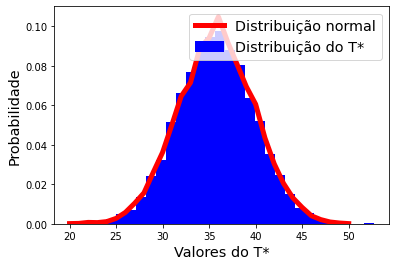

In [23]:
import matplotlib.pyplot as plt

count, bins, ignored = plt.hist(s, 30, density=True,color='b')


plt.plot(list(distribution.keys()), list(distribution.values()), color = 'r',lw=5)
plt.rcParams["figure.figsize"] = (15, 10)
plt.legend(['Distribuição normal','Distribuição do T*'],loc='best',fontsize='x-large') # colocar legenda

plt.ylabel('Probabilidade',fontsize='x-large')
plt.xlabel('Valores do T*',fontsize='x-large')  

plt.show()